# RNA_adapter_kClustering analysis v3

In [68]:
# Mark : Autogenerated with openBIS-ELN/LIMS (System Cell, Don't delete!)

In [69]:
# Variable - File Name (System Cell, Don't delete!, Update if renamed)
fileName='kmeans_average_F320.ipynb'
workspace='ngs/sander/phage_infection_time_course_e_coli_rnaseq/yan_results/'

In [70]:
# Variable : Parents used by the automaticaly generated result dataset (System Cell, Don't delete!)
resultDatasetParents=[workspace]

### Connect to openBIS

In [71]:
import obis_connector
o = obis_connector.connect_to_openbis(url='http://openngs.bio.ed.ac.uk:8443')

Using hardcoded url instead: http://openngs2.bio.ed.ac.uk:8443


### Process your data here

In [284]:
import sys
sys.path.append("/homes2/openngs/openngs/classes/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(color_codes=True)
from pyCRAC.Parsers import GTF2
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr,spearmanr
from sg_ngs_tools import CountsNormalization
matplotlib.rcParams['font.family'] = "Arial"
%matplotlib inline

In [73]:
def logTransform(data):
    """ Log transforms the data in the DataFrame."""
    lognorm = data.apply(lambda x: np.log10(x))
    return lognorm.replace([np.nan,np.inf],0)

In [234]:
def ElbowMethod (data,x):
    X = data.values
    distortions = []
    K = range(1,x)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig('The Elbow Method showing the optimal k',dpi=400)
    plt.show()

In [264]:
def makeClusterPlots_new(clustereddata,name):
    profiles = sorted(list(set(clustereddata["cluster"].values)))
    numberofplots = len(profiles)
    fig,ax = plt.subplots(nrows=numberofplots,sharey=True)
    fig.subplots_adjust(top=None, wspace=None, hspace=0.5)
    fig.set_figheight(5*numberofplots)
    fig.set_figwidth(6)
    count = 0
    for profile in profiles:
        data = clustereddata[clustereddata["cluster"] == profile][clustereddata.columns[:-2]]
        #data.columns = [float(i) for i in data.columns]
        counts = countClusterAnnotations(data)
        #ax[count].pie(counts.values(),labels=counts.keys(),shadow=True,startangle=90)
        ax[count].set_xticks(np.arange(len(data.columns)))
        ax[count].set_xticklabels(data.columns)
        ax[count].axhline(y=0,color='black',ls='dashed')
        ax[count].set_xlabel("treatment",fontsize=12)
        ax[count].set_ylabel("log10 fold change",fontsize=12)
        ax[count].set_title("Cluster %s" % profile,fontsize=14)
        ax[count].plot(data.columns,np.mean(data,axis=0),c="black",linewidth=2)
        ax[count].legend(["n = %s" % len(data.index)],loc=2)
        for gene in data.index:
            x = data.columns
            y = data.loc[gene]
            ax[count].plot(x,y,c=clustereddata.loc[gene,'Colour'],alpha=0.8)
        count += 1
    fig.savefig("%s_K-means_clusters.pdf" % name,dpi=400)

## Load the data

In [236]:
gtf = GTF2.Parse_GTF()
gtf.read_GTF("Escherichia_coli_K12_and_T1_phage_genome.gtf")

In [237]:
mean = pd.read_table("t1_mean_F320.csv")

In [238]:
mean

,gene_name,mean_C0,mean_C20,mean_E5,mean_E10,mean_E15,mean_E20,sum
0,77,0,0,19621.094109,11242.879975,5183.396536,2905.850551,38953.221172
1,76,0,0,19628.497438,12323.549721,5848.864376,3285.009052,41085.920587
2,75,0,0,39794.918880,19746.957128,7551.296073,3692.954911,70786.126992
3,74,0,0,37388.479726,21303.902087,8744.578130,4400.213570,71837.173513
4,73,0,0,43658.282644,26883.366160,11519.531572,6110.382456,88171.562832
...,...,...,...,...,...,...,...,...
73,05,0,0,41647.602865,27367.478455,13426.228421,5366.104632,87807.414372
74,04,0,0,20308.532317,13066.325900,6166.360485,2760.214079,42301.432781
75,03,0,0,17327.319200,11079.489731,5455.271431,2526.122441,36388.202803
76,02,0,0,20732.939503,11341.054078,4353.239961,1834.579040,38261.812582


In [239]:
mean.set_index('gene_name',inplace=True)
# or mean=mean.sort_index(axis='index')

In [240]:
mean = mean.sort_index(axis='index')

In [241]:
mean

,mean_C0,mean_C20,mean_E5,mean_E10,mean_E15,mean_E20,sum
gene_name,,,,,,,
01,0,0,21307.220045,10554.569938,3626.180406,1437.572280,36925.542669
02,0,0,20732.939503,11341.054078,4353.239961,1834.579040,38261.812582
03,0,0,17327.319200,11079.489731,5455.271431,2526.122441,36388.202803
04,0,0,20308.532317,13066.325900,6166.360485,2760.214079,42301.432781
05,0,0,41647.602865,27367.478455,13426.228421,5366.104632,87807.414372
...,...,...,...,...,...,...,...
73,0,0,43658.282644,26883.366160,11519.531572,6110.382456,88171.562832
74,0,0,37388.479726,21303.902087,8744.578130,4400.213570,71837.173513
75,0,0,39794.918880,19746.957128,7551.296073,3692.954911,70786.126992


In [242]:
# get rid of the control data
mean = mean.loc[:,'mean_E5':'mean_E20']

In [243]:
mean

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280
02,20732.939503,11341.054078,4353.239961,1834.579040
03,17327.319200,11079.489731,5455.271431,2526.122441
04,20308.532317,13066.325900,6166.360485,2760.214079
05,41647.602865,27367.478455,13426.228421,5366.104632
...,...,...,...,...
73,43658.282644,26883.366160,11519.531572,6110.382456
74,37388.479726,21303.902087,8744.578130,4400.213570
75,39794.918880,19746.957128,7551.296073,3692.954911


In [244]:
div_time_5 = pd.DataFrame()

In [245]:
column_names = mean.columns

In [246]:
div_time_5[column_names] = mean[column_names]

In [247]:
div_time_5.head()

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280
02,20732.939503,11341.054078,4353.239961,1834.579040
03,17327.319200,11079.489731,5455.271431,2526.122441
04,20308.532317,13066.325900,6166.360485,2760.214079
05,41647.602865,27367.478455,13426.228421,5366.104632


In [248]:
div_time_5 = div_time_5.div(div_time_5['mean_E5'],axis=0)

In [249]:
div_time_5

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,1.0,0.495352,0.170186,0.067469
02,1.0,0.547007,0.209967,0.088486
03,1.0,0.639423,0.314836,0.145788
04,1.0,0.643391,0.303634,0.135914
05,1.0,0.657120,0.322377,0.128845
...,...,...,...,...
73,1.0,0.615768,0.263857,0.139959
74,1.0,0.569799,0.233884,0.117689
75,1.0,0.496218,0.189755,0.092800


In [250]:
div_5_log10norm = logTransform(div_time_5)

In [251]:
div_5_log10norm.tail()

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
73,0.0,-0.210583,-0.578632,-0.853998
74,0.0,-0.244279,-0.630999,-0.929264
75,0.0,-0.304327,-0.721806,-1.032454
76,0.0,-0.202151,-0.525816,-0.776350
77,0.0,-0.241846,-0.578109,-0.829450


In [235]:
div_5_log10norm.tail()

,mean_E5,mean_E10,mean_E15,mean_E20,cluster
gene_name,,,,,
73,0.0,-0.210583,-0.578632,-0.853998,1
74,0.0,-0.244279,-0.630999,-0.929264,1
75,0.0,-0.304327,-0.721806,-1.032454,1
76,0.0,-0.202151,-0.525816,-0.776350,1
77,0.0,-0.241846,-0.578109,-0.829450,1


### Define optimal number of clusters

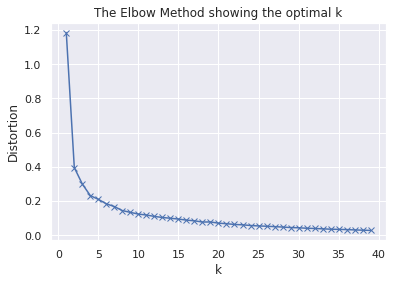

In [252]:
ElbowMethod(div_5_log10norm,x=40)

### Now K-means clustering the data

In [253]:
kmeans = KMeans(n_clusters=4, random_state=0) # doing the K-means clustering. Asking for 10 clusters

In [254]:
kmeans.fit(div_5_log10norm)

KMeans(n_clusters=4, random_state=0)

In [255]:
div_5_log10norm["cluster"] = kmeans.labels_

In [256]:
div_5_log10norm.loc[div_5_log10norm['cluster']==3]

,mean_E5,mean_E10,mean_E15,mean_E20,cluster
gene_name,,,,,
14,0.0,-0.067491,0.044463,0.150147,3
15,0.0,-0.109180,-0.003706,0.058886,3
16,0.0,0.095626,0.229783,0.313954,3
21,0.0,-0.122779,-0.233323,-0.202442,3
24,0.0,-0.043471,-0.083658,-0.151051,3
27,0.0,0.318907,0.256783,0.080276,3
28,0.0,0.211723,-0.026337,-0.326504,3
30,0.0,-0.010247,-0.119657,-0.046313,3
55,0.0,0.396675,0.501667,0.253152,3


In [119]:
# yellow represents gold group
tmp = div_5_log10norm.copy()
tmp["Colour"]=""
black1_group = ['01','02','03','04','05','06','07']
black2_group = ['10','14','17','18','21','23','25']         
black3_group = ['55','56','57','58','59','60','61']
black4_group = ['65','66','67','68','69','70','71','72','73','74','75','76','77']
yellow_group = ['08','15','20','22','24',
              '27','28','29',
             '62','63A','63','64']
green_group = ['09','16','19','39','40']
red_group = ['11','12','13']
purple_group = ['26',
                '31','32','33','34','35','36','37','38']
light_blue_group = ['30']
blue_group = ['41','42','43','44','45','46','47','48','49','50','51','52']
brown_group = ['53','54']
for gene in tmp.index:
    if gene in black1_group:
        tmp.loc[gene,"Colour"]="black"
    if gene in black2_group:
        tmp.loc[gene,"Colour"]="black"
    if gene in black3_group:
        tmp.loc[gene,"Colour"]="black"
    if gene in black4_group:
        tmp.loc[gene,"Colour"]="black"
    if gene in yellow_group:
        tmp.loc[gene,"Colour"]="yellow"
    if gene in green_group:
        tmp.loc[gene,"Colour"]="green"
    if gene in red_group:
        tmp.loc[gene,"Colour"]="red"
    if gene in purple_group:
        tmp.loc[gene,"Colour"]="purple"
    if gene in light_blue_group:
        tmp.loc[gene,"Colour"]="cyan"
    if gene in blue_group:
        tmp.loc[gene,"Colour"]="blue"
    if gene in brown_group:
        tmp.loc[gene,"Colour"]="brown"

In [30]:
#tmp['average'] = tmp.loc[:,'mean_E5':'mean_E20'].mean(axis=1)

In [122]:
tmp.loc[tmp['cluster']==0]

,mean_E5,mean_E10,mean_E15,mean_E20,cluster,Colour
gene_name,,,,,,
23,0.0,0.621638,0.534393,0.404609,0,black
31,0.0,0.543789,0.754235,0.824250,0,purple
32,0.0,0.655033,0.824065,0.864462,0,purple
34,0.0,0.644704,0.962698,1.152790,0,purple
35,0.0,0.476131,0.728824,0.868371,0,purple
36,0.0,0.461551,0.655655,0.749934,0,purple
37,0.0,0.543307,0.820700,1.031229,0,purple
38,0.0,0.596275,0.930611,1.139899,0,purple
43,0.0,0.502943,0.871523,1.057024,0,blue


In [231]:
tmp.loc[tmp['cluster']==1]

,mean_E5,mean_E10,mean_E15,mean_E20,cluster,Colour
gene_name,,,,,,
01,0.0,-0.305086,-0.769077,-1.170897,1,black
02,0.0,-0.262007,-0.677848,-1.053124,1,black
03,0.0,-0.194212,-0.501915,-0.836277,1,black
04,0.0,-0.191525,-0.517650,-0.866736,1,black
05,0.0,-0.182355,-0.491636,-0.889931,1,black
06,0.0,-0.152656,-0.465887,-0.865615,1,black
07,0.0,-0.463085,-0.836762,-1.193011,1,black
08,0.0,-0.405843,-0.730777,-1.064767,1,yellow
09,0.0,-0.275502,-0.539363,-0.800893,1,green


In [232]:
tmp.loc[tmp['cluster']==2]

,mean_E5,mean_E10,mean_E15,mean_E20,cluster,Colour
gene_name,,,,,,
11,0.0,0.697026,1.192746,1.445448,2,red
12,0.0,1.040848,1.584658,1.835730,2,red
13,0.0,1.319616,1.888727,2.113252,2,red
25,0.0,0.972014,1.023138,1.082493,2,black
26,0.0,1.160993,1.266711,1.294649,2,purple
33,0.0,1.116159,1.265582,1.335798,2,purple
39,0.0,0.874543,1.129421,1.237262,2,green
40,0.0,0.868902,1.051203,1.044851,2,green
41,0.0,0.822859,1.182979,1.418035,2,blue


In [233]:
tmp.loc[tmp['cluster']==3]

,mean_E5,mean_E10,mean_E15,mean_E20,cluster,Colour
gene_name,,,,,,
14,0.0,-0.067491,0.044463,0.150147,3,black
15,0.0,-0.109180,-0.003706,0.058886,3,yellow
16,0.0,0.095626,0.229783,0.313954,3,green
21,0.0,-0.122779,-0.233323,-0.202442,3,black
24,0.0,-0.043471,-0.083658,-0.151051,3,yellow
27,0.0,0.318907,0.256783,0.080276,3,yellow
28,0.0,0.211723,-0.026337,-0.326504,3,yellow
30,0.0,-0.010247,-0.119657,-0.046313,3,cyan
55,0.0,0.396675,0.501667,0.253152,3,black


maxp pruned

cmap pruned

kern dropped

post pruned

FFTM dropped

GPOS pruned

GSUB pruned

name pruned

glyf pruned

Added gid0 to subset

Added first four glyphs to subset

Closing glyph list over 'GSUB': 31 glyphs before

Glyph names: ['.notdef', '.null', 'C', 'E', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'g', 'h', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'zero']

Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 32, 38, 40, 66, 68, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 85, 86, 87, 88, 3228]

Closed glyph list over 'GSUB': 34 glyphs after

Glyph names: ['.notdef', '.null', 'C', 'E', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'fl', 'g', 'h', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'uniFB00', 'uniFB04', 'zero']

Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 32, 38, 40, 66, 68, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 85, 86, 87, 88, 3228, 5038, 5040, 5042]

Closing glyph list over 'MATH': 34 glyphs before

Glyph names: ['.notdef', '.null', 'C', 'E', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'fl', 'g', 'h', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'uniFB00', 'uniFB04', 'zero']

Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 32, 38, 40, 66, 68, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 85, 86, 87, 88, 3228, 5038, 5040, 5042]

Closed glyph list over 'MATH': 34 glyphs after

Glyph names: ['.notdef', '.null', 'C', 'E', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'fl', 'g', 'h', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'uniFB00', 'uniFB04', 'zero']

Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 32, 38, 40, 66, 68, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 85, 86, 87, 88, 3228, 5038, 5040, 5042]

Closing glyph list over 'glyf': 34 glyphs before

Glyph names: ['.notdef', '.null', 'C', 'E', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'fl', 'g', 'h', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'uniFB00', 'uniFB04', 'zero']

Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 32, 38, 40, 66, 68, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 85, 86, 87, 88, 3228, 5038, 5040, 5042]

Closed glyph list over 'glyf': 34 glyphs after

Glyph names: ['.notdef', '.null', 'C', 'E', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'fl', 'g', 'h', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'uniFB00', 'uniFB04', 'zero']

Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 32, 38, 40, 66, 68, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 85, 86, 87, 88, 3228, 5038, 5040, 5042]

Retaining 34 glyphs

head subsetting not needed

hhea subsetting not needed

maxp subsetting not needed

OS/2 subsetting not needed

hmtx subsetted

cmap subsetted

fpgm subsetting not needed

prep subsetting not needed

cvt  subsetting not needed

loca subsetting not needed

post subsetted

gasp subsetting not needed

GDEF subsetted

GPOS subsetted

GSUB subsetted

MATH subsetted

name subsetting not needed

glyf subsetted

head pruned

OS/2 Unicode ranges pruned: [0, 38]

glyf pruned

GDEF pruned

GPOS pruned

GSUB pruned

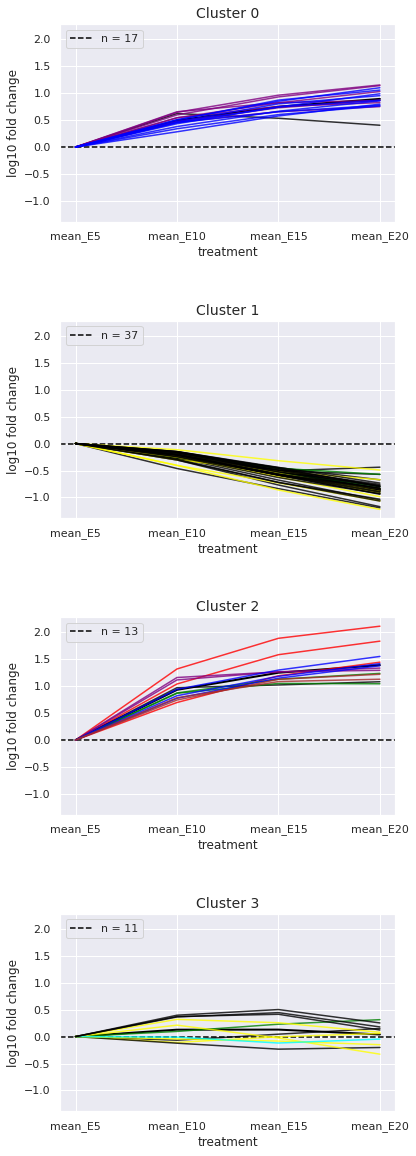

In [265]:
makeClusterPlots_new(tmp,'test_F320_cluster_4_alpha0.8')

In [127]:
tmp.head()

,mean_E5,mean_E10,mean_E15,mean_E20,cluster,Colour
gene_name,,,,,,
01,0.0,-0.305086,-0.769077,-1.170897,1,black
02,0.0,-0.262007,-0.677848,-1.053124,1,black
03,0.0,-0.194212,-0.501915,-0.836277,1,black
04,0.0,-0.191525,-0.517650,-0.866736,1,black
05,0.0,-0.182355,-0.491636,-0.889931,1,black


### Calculate average expression level of each gene 

In [53]:
mean.head()

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280
02,20732.939503,11341.054078,4353.239961,1834.579040
03,17327.319200,11079.489731,5455.271431,2526.122441
04,20308.532317,13066.325900,6166.360485,2760.214079
05,41647.602865,27367.478455,13426.228421,5366.104632


In [299]:
mean.head()

,mean_E5,mean_E10,mean_E15,mean_E20,average,Colour,error
gene_name,,,,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280,9231.385667,black,8939.396804
02,20732.939503,11341.054078,4353.239961,1834.579040,9565.453145,black,8461.660415
03,17327.319200,11079.489731,5455.271431,2526.122441,9097.050701,black,6534.703220
04,20308.532317,13066.325900,6166.360485,2760.214079,10575.358195,black,7777.217518
05,41647.602865,27367.478455,13426.228421,5366.104632,21951.853593,black,15968.979149


In [257]:
mean.head()

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280
02,20732.939503,11341.054078,4353.239961,1834.579040
03,17327.319200,11079.489731,5455.271431,2526.122441
04,20308.532317,13066.325900,6166.360485,2760.214079
05,41647.602865,27367.478455,13426.228421,5366.104632


In [258]:
mean['average'] = mean.loc[:,'mean_E5':'mean_E20'].mean(axis=1)

In [259]:
mean.head()

,mean_E5,mean_E10,mean_E15,mean_E20,average
gene_name,,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280,9231.385667
02,20732.939503,11341.054078,4353.239961,1834.579040,9565.453145
03,17327.319200,11079.489731,5455.271431,2526.122441,9097.050701
04,20308.532317,13066.325900,6166.360485,2760.214079,10575.358195
05,41647.602865,27367.478455,13426.228421,5366.104632,21951.853593


In [260]:
mean["Colour"]=""
black1_group = ['01','02','03','04','05','06','07']
black2_group = ['10','14','17','18','21','23','25']         
black3_group = ['55','56','57','58','59','60','61']
black4_group = ['65','66','67','68','69','70','71','72','73','74','75','76','77']
yellow_group = ['08','15','20','22','24',
              '27','28','29',
             '62','63A','63','64']
green_group = ['09','16','19','39','40']
red_group = ['11','12','13']
purple_group = ['26',
                '31','32','33','34','35','36','37','38']
light_blue_group = ['30']
blue_group = ['41','42','43','44','45','46','47','48','49','50','51','52']
brown_group = ['53','54']
for gene in mean.index:
    if gene in black1_group:
        mean.loc[gene,"Colour"]="black"
    if gene in black2_group:
        mean.loc[gene,"Colour"]="black"
    if gene in black3_group:
        mean.loc[gene,"Colour"]="black"
    if gene in black4_group:
        mean.loc[gene,"Colour"]="black"
    if gene in yellow_group:
        mean.loc[gene,"Colour"]="yellow"
    if gene in green_group:
        mean.loc[gene,"Colour"]="green"
    if gene in red_group:
        mean.loc[gene,"Colour"]="red"
    if gene in purple_group:
        mean.loc[gene,"Colour"]="purple"
    if gene in light_blue_group:
        mean.loc[gene,"Colour"]="cyan"
    if gene in blue_group:
        mean.loc[gene,"Colour"]="blue"
    if gene in brown_group:
        mean.loc[gene,"Colour"]="brown"

In [261]:
mean["error"] = mean.loc[:,"mean_E5":"mean_E20"].std(axis=1)

In [262]:
mean.head()

,mean_E5,mean_E10,mean_E15,mean_E20,average,Colour,error
gene_name,,,,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280,9231.385667,black,8939.396804
02,20732.939503,11341.054078,4353.239961,1834.579040,9565.453145,black,8461.660415
03,17327.319200,11079.489731,5455.271431,2526.122441,9097.050701,black,6534.703220
04,20308.532317,13066.325900,6166.360485,2760.214079,10575.358195,black,7777.217518
05,41647.602865,27367.478455,13426.228421,5366.104632,21951.853593,black,15968.979149


In [303]:
mean_nosum_group = mean.iloc[:-8]

In [305]:
mean_nosum_group.index

Index(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '63A', '64', '65', '66', '67', '68', '69', '70', '71',
       '72', '73', '74', '75', '76', '77'],
      dtype='object', name='gene_name')

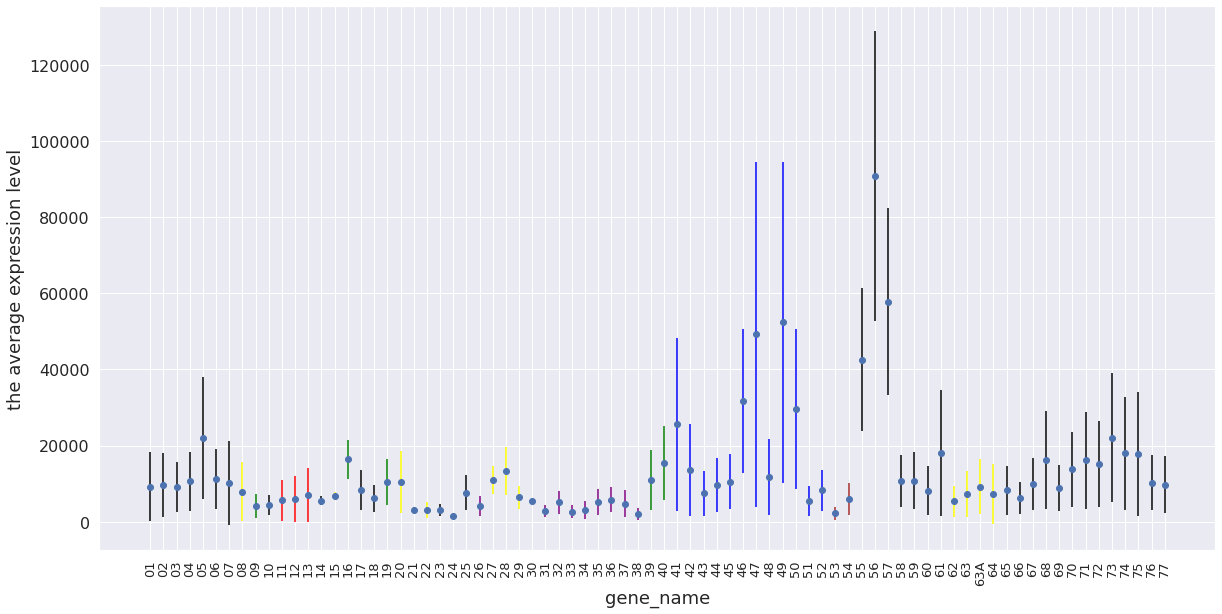

In [312]:
#list(mean["average"])
name=[]
for i in list(mean_nosum_group.index):
    name.append(i)
#mean.plot.scatter(x=list(mean.index),y="average")

plt.figure(figsize=(20, 10))
plt.xlabel('gene_name',fontsize=18)
plt.ylabel('the average expression level',fontsize=18)
#plt.scatter(x=name,y=list(mean["average"]),c=list(mean["Colour"]))
plt.errorbar(x=name,y=list(mean_nosum_group["average"]),ecolor=list(mean_nosum_group["Colour"]),yerr=list(mean_nosum_group["error"]),fmt="o")
plt.xticks(rotation=90,fontsize=13)
plt.yticks(fontsize=16)
#plt.title('transcript level of each gene in T1 of all time points')
#plt.show()
plt.savefig("average_epression_level_Yan_F320",dpi=400)

In [313]:
data_for_lognorm = mean_nosum_group.loc[:,'mean_E5':'mean_E20']

In [314]:
data_for_lognorm.head()

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,21307.220045,10554.569938,3626.180406,1437.572280
02,20732.939503,11341.054078,4353.239961,1834.579040
03,17327.319200,11079.489731,5455.271431,2526.122441
04,20308.532317,13066.325900,6166.360485,2760.214079
05,41647.602865,27367.478455,13426.228421,5366.104632


In [315]:
meanlognorm = logTransform(data_for_lognorm)

In [316]:
meanlognorm.head()

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
01,4.328527,4.023441,3.559449,3.157630
02,4.316661,4.054653,3.638813,3.263536
03,4.238731,4.044520,3.736816,3.402454
04,4.307679,4.116153,3.790029,3.440943
05,4.619590,4.437235,4.127954,3.729659


In [317]:
meanlognorm["Colour"]=""
black1_group = ['01','02','03','04','05','06','07']
black2_group = ['10','14','17','18','21','23','25']         
black3_group = ['55','56','57','58','59','60','61']
black4_group = ['65','66','67','68','69','70','71','72','73','74','75','76','77']
yellow_group = ['08','15','20','22','24',
              '27','28','29',
             '62','63A','63','64']
green_group = ['09','16','19','39','40']
red_group = ['11','12','13']
purple_group = ['26',
                '31','32','33','34','35','36','37','38']
light_blue_group = ['30']
blue_group = ['41','42','43','44','45','46','47','48','49','50','51','52']
brown_group = ['53','54']
for gene in meanlognorm.index:
    if gene in black1_group:
        meanlognorm.loc[gene,"Colour"]="black"
    if gene in black2_group:
        meanlognorm.loc[gene,"Colour"]="black"
    if gene in black3_group:
        meanlognorm.loc[gene,"Colour"]="black"
    if gene in black4_group:
        meanlognorm.loc[gene,"Colour"]="black"
    if gene in yellow_group:
        meanlognorm.loc[gene,"Colour"]="yellow"
    if gene in green_group:
        meanlognorm.loc[gene,"Colour"]="green"
    if gene in red_group:
        meanlognorm.loc[gene,"Colour"]="red"
    if gene in purple_group:
        meanlognorm.loc[gene,"Colour"]="purple"
    if gene in light_blue_group:
        meanlognorm.loc[gene,"Colour"]="cyan"
    if gene in blue_group:
        meanlognorm.loc[gene,"Colour"]="blue"
    if gene in brown_group:
        meanlognorm.loc[gene,"Colour"]="brown"

In [318]:
meanlognorm["error"] = meanlognorm.loc[:,"mean_E5":"mean_E20"].std(axis=1)

In [319]:
meanlognorm['average'] = meanlognorm.loc[:,'mean_E5':'mean_E20'].mean(axis=1)

In [320]:
meanlognorm

,mean_E5,mean_E10,mean_E15,mean_E20,Colour,error,average
gene_name,,,,,,,
01,4.328527,4.023441,3.559449,3.157630,black,0.514938,3.767262
02,4.316661,4.054653,3.638813,3.263536,black,0.463395,3.818416
03,4.238731,4.044520,3.736816,3.402454,black,0.366029,3.855630
04,4.307679,4.116153,3.790029,3.440943,black,0.380789,3.913701
05,4.619590,4.437235,4.127954,3.729659,black,0.389647,4.228609
...,...,...,...,...,...,...,...
73,4.640067,4.429484,4.061435,3.786068,black,0.380103,4.229263
74,4.572738,4.328459,3.941739,3.643474,black,0.411206,4.121602
75,4.599828,4.295500,3.878021,3.567374,black,0.454655,4.085181


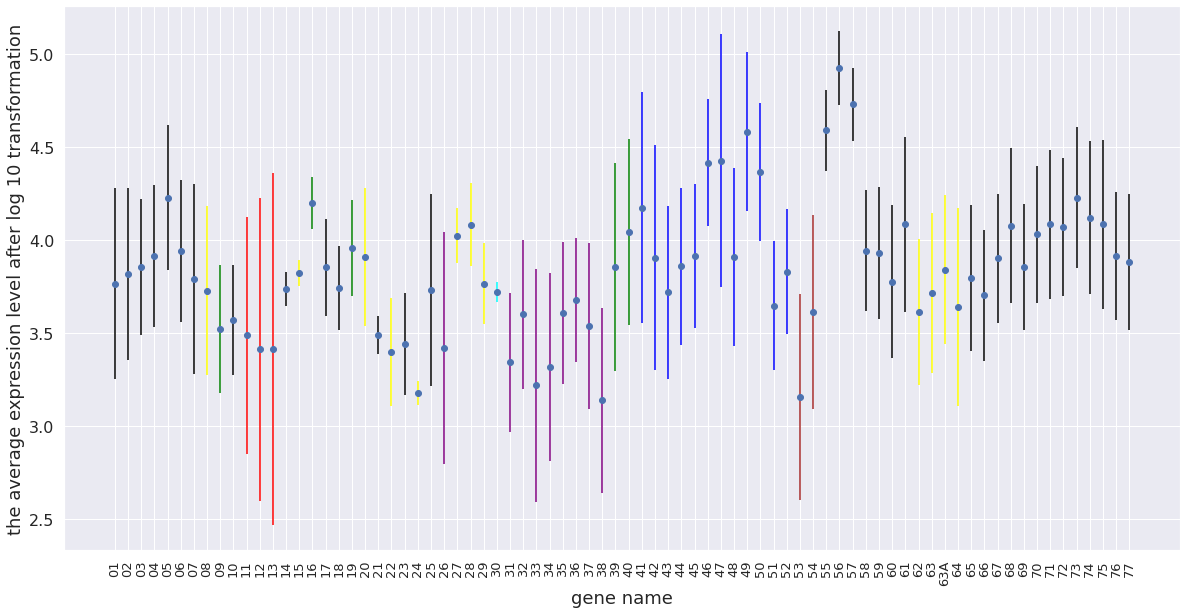

In [323]:
#list(mean["average"])
name=[]
for i in list(meanlognorm.index):
    name.append(i)
#mean.plot.scatter(x=list(mean.index),y="average")
#fmt_color={"blue":"bo","green":"go","yellow":"yo","black":"ko","red":"ro","cyan":"co","brown":"wo","purple":"mo"}
#fmt_c=[fmt_color[i] for i in list(mean["Colour"])]
plt.figure(figsize=(20, 10))
#plt.scatter(x=name,y=list(mean["average"]),c=list(mean["Colour"]))

plt.errorbar(x=name,y=list(meanlognorm["average"]),ecolor=list(meanlognorm["Colour"]),yerr=list(meanlognorm["error"]),fmt="o")
plt.xticks(rotation=90,fontsize=13)
plt.yticks(fontsize=16)
plt.xlabel('gene name',fontsize=18)
plt.ylabel('the average expression level after log 10 transformation',fontsize=18)
#plt.title('transcript level of each T1 gene of all time points after log 10 transformation')
#plt.show()
plt.savefig("average_level of each gene after log10 transformation",dpi=400)

### Percentage of different groups of gene in each time point

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [43]:
def add_text(x, y, data, fontsize=12):
    for x0, y0, data0 in zip(x, y, data):
        axs[1].text(x0, y0, round(data0, 1), rotation=90)

In [150]:
group_expr_percentage = pd.DataFrame()

In [160]:
mean.tail()

,mean_E5,mean_E10,mean_E15,mean_E20,average,Colour,error
gene_name,,,,,,,
red,773.071113,6981.616766,24129.629499,42066.343198,18487.665144,redredred,18570.102050
purple,6639.853948,28454.592851,46045.546729,59964.205666,35276.049799,purplepurplepurplepurplepurplepurplepurplepurp...,23471.299989
light_blue,5834.523188,5698.467414,4429.438013,5244.356373,5301.696247,cyan,633.891210
blue,45975.600585,153400.375508,312669.794308,508530.006493,255143.944223,blueblueblueblueblueblueblueblueblueblueblueblue,201912.499840
brown,975.533683,5807.528383,12181.358127,13907.018625,8217.859705,brownbrown,5965.519661


In [266]:
mean.loc['black'] = mean.loc[mean['Colour']=='black'].sum()
mean.loc['green'] = mean.loc[mean['Colour']=='green'].sum()
mean.loc['red'] = mean.loc[mean['Colour']=='red'].sum()
mean.loc['purple'] = mean.loc[mean['Colour']=='purple'].sum()
mean.loc['light_blue'] = mean.loc[mean['Colour']=='cyan'].sum()
mean.loc['blue'] = mean.loc[mean['Colour']=='blue'].sum()
mean.loc['brown'] = mean.loc[mean['Colour']=='brown'].sum()
mean.loc['yellow'] = mean.loc[mean['Colour']=='yellow'].sum()

In [267]:
mean.loc['black':'yellow']

,mean_E5,mean_E10,mean_E15,mean_E20,average,Colour,error
gene_name,,,,,,,
black,751268.962048,639231.190711,472213.900809,260511.360709,530806.353569,blackblackblackblackblackblackblackblackblackb...,337878.250632
green,40882.747405,53125.765948,64933.184392,70230.299640,57292.999346,greengreengreengreengreen,31932.049688
red,773.071113,6981.616766,24129.629499,42066.343198,18487.665144,redredred,18570.102050
purple,6639.853948,28454.592851,46045.546729,59964.205666,35276.049799,purplepurplepurplepurplepurplepurplepurplepurp...,23471.299989
light_blue,5834.523188,5698.467414,4429.438013,5244.356373,5301.696247,cyan,633.891210
blue,45975.600585,153400.375508,312669.794308,508530.006493,255143.944223,blueblueblueblueblueblueblueblueblueblueblueblue,201912.499840
brown,975.533683,5807.528383,12181.358127,13907.018625,8217.859705,brownbrown,5965.519661
yellow,147649.708029,107300.462419,63397.148123,39546.409296,89473.431967,yellowyellowyellowyellowyellowyellowyellowyell...,57337.482150


In [268]:
group_expr_percentage = mean.loc['black':'yellow','mean_E5':'mean_E20']

In [269]:
group_expr_percentage

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
black,751268.962048,639231.190711,472213.900809,260511.360709
green,40882.747405,53125.765948,64933.184392,70230.299640
red,773.071113,6981.616766,24129.629499,42066.343198
purple,6639.853948,28454.592851,46045.546729,59964.205666
light_blue,5834.523188,5698.467414,4429.438013,5244.356373
blue,45975.600585,153400.375508,312669.794308,508530.006493
brown,975.533683,5807.528383,12181.358127,13907.018625
yellow,147649.708029,107300.462419,63397.148123,39546.409296


In [270]:
column_names = group_expr_percentage.columns

In [271]:
group_expr_percentage[column_names] = group_expr_percentage[column_names].apply(lambda x: x/x.sum(),axis=0)

In [272]:
group_expr_percentage

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
black,0.751269,0.639231,0.472214,0.260511
green,0.040883,0.053126,0.064933,0.070230
red,0.000773,0.006982,0.024130,0.042066
purple,0.006640,0.028455,0.046046,0.059964
light_blue,0.005835,0.005698,0.004429,0.005244
blue,0.045976,0.153400,0.312670,0.508530
brown,0.000976,0.005808,0.012181,0.013907
yellow,0.147650,0.107300,0.063397,0.039546


In [273]:
group_expr_percentage.loc['sum'] = group_expr_percentage.sum()

In [274]:
group_expr_percentage

,mean_E5,mean_E10,mean_E15,mean_E20
gene_name,,,,
black,0.751269,0.639231,0.472214,0.260511
green,0.040883,0.053126,0.064933,0.070230
red,0.000773,0.006982,0.024130,0.042066
purple,0.006640,0.028455,0.046046,0.059964
light_blue,0.005835,0.005698,0.004429,0.005244
blue,0.045976,0.153400,0.312670,0.508530
brown,0.000976,0.005808,0.012181,0.013907
yellow,0.147650,0.107300,0.063397,0.039546
sum,1.000000,1.000000,1.000000,1.000000


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

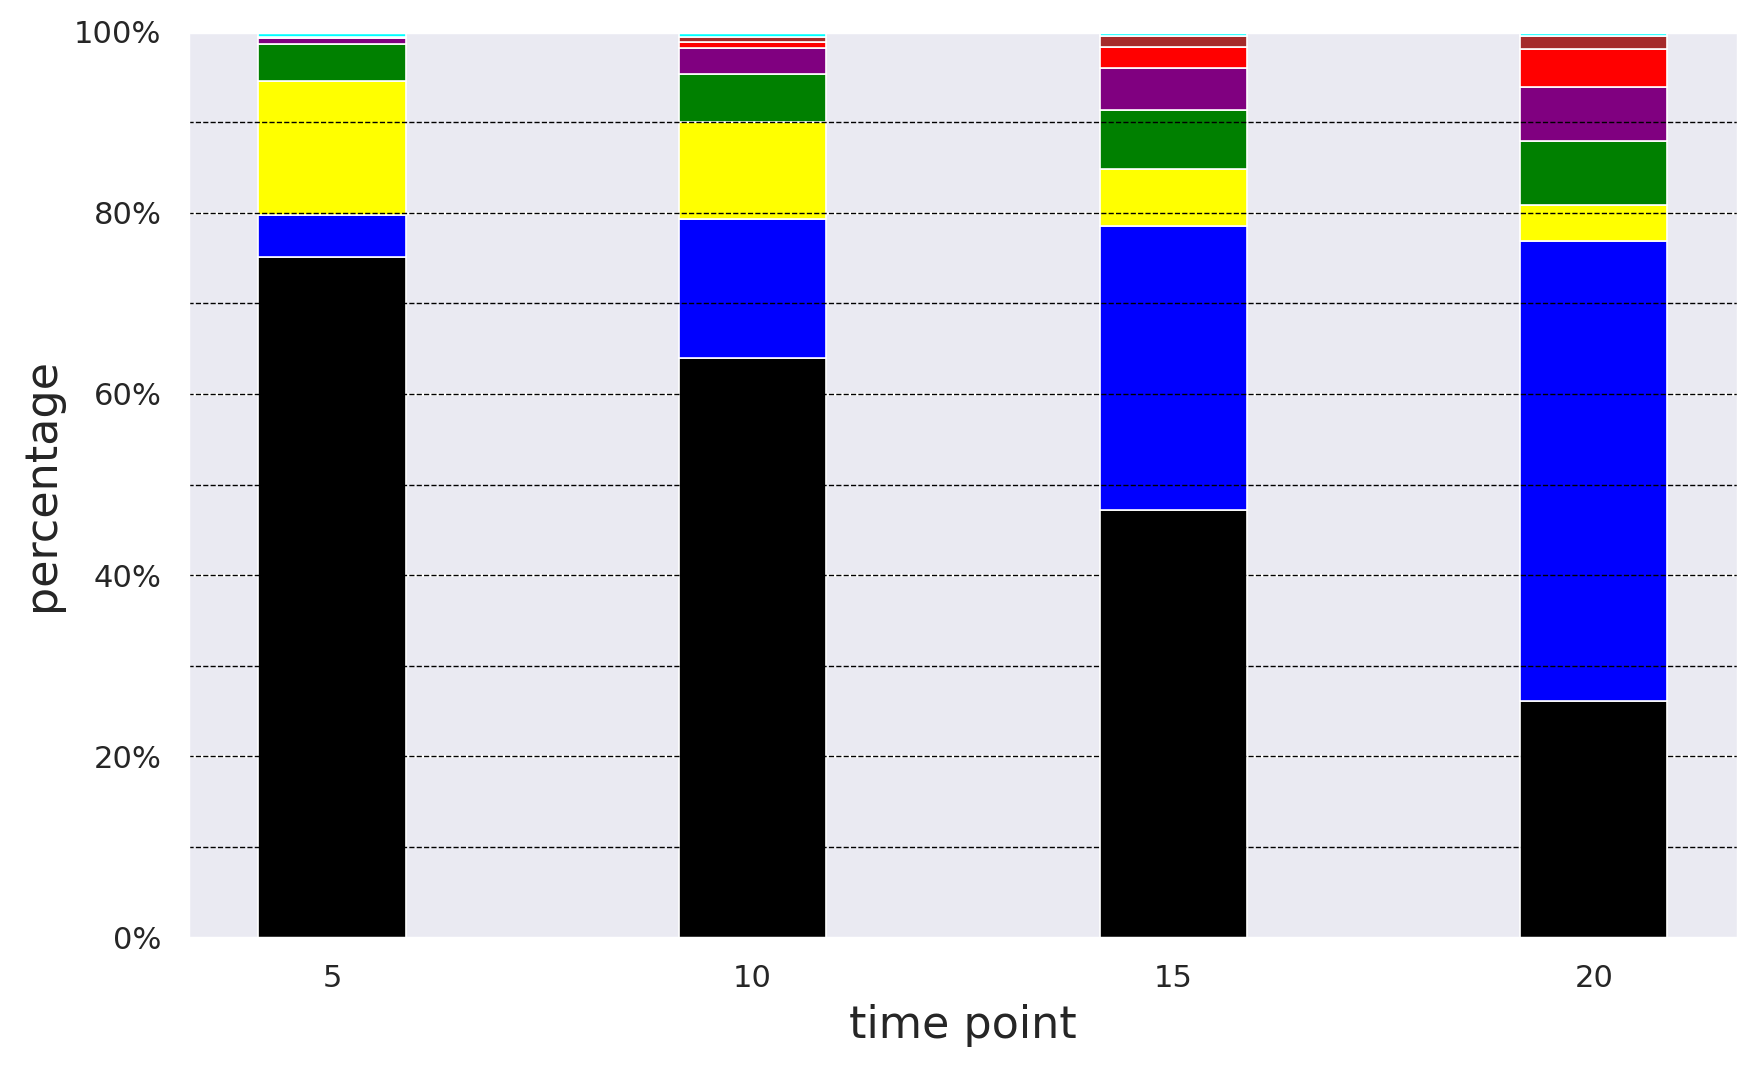

In [285]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
labels = ['5','10','15','20']
#labels = group_expr_percentage.columns.values.tolist()  

black = group_expr_percentage.loc['black']
green = group_expr_percentage.loc['green']
red = group_expr_percentage.loc['red']
purple = group_expr_percentage.loc['purple']
light_blue = group_expr_percentage.loc['light_blue']
blue = group_expr_percentage.loc['blue']
brown = group_expr_percentage.loc['brown']
yellow = group_expr_percentage.loc['yellow']
data = [black,green,red,purple,light_blue,blue,brown,yellow]


plt.rcParams['font.sans-serif'] = ['SimHei']
figsize = 16,6

width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(10,6),dpi=200)
ax.bar(labels, black, width, label='black',color='black',lw=.6)
ax.bar(labels, blue, width, bottom=black, label='blue',color='blue',lw=.6)
ax.bar(labels, yellow, width, bottom=blue+black, label='yellow',color='yellow',lw=.6)
ax.bar(labels, green, width, bottom=yellow+blue+black, label='green',color='green',lw=.6)
ax.bar(labels, purple, width, bottom=green+yellow+blue+black, label='purple',color='purple',lw=.6)
ax.bar(labels, red, width, bottom=purple+green+yellow+blue+black, label='red',color='red',lw=.6)
ax.bar(labels, brown, width, bottom=red+purple+green+yellow+blue+black, label='brown',color='brown',lw=.6)
ax.bar(labels, light_blue, width, bottom=brown+red+purple+green+yellow+blue+black, label='light_blue',color='cyan',lw=.6)


ax.set_ylim(0,1)
ax.set_ylabel('percentage',fontsize=16)
ax.set_xlabel('time point',fontsize=16)


#ax.tick_params(axis='both',direction='out')

#纵轴设置为百分比
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#绘制平行于x轴的虚线
for i in range(1, 11, 1):
    plt.axhline(y=i/10, linestyle='dashed', color='black', linewidth=0.5)
labels = ax.get_xticklabels() + ax.get_yticklabels()
#设置数字label字体
#[label.set_fontname('Times New Roman') for label in labels]
#legend_labels = ['black','green','red','purple','cyan','blue','brown',]
#color = ['black','green','red','purple','cyan','blue','brown','yellow']
#patches = [mpatches.Patch(color=color[h],label="{:s}".format(legend_labels[h])) for h in range(len(legend_labels))]
#ax.legend(handles=patches,ncol=1, bbox_to_anchor=(1, 1), borderaxespad = 0.)  # 生成legend
#plt.subplots_adjust(right=0.7)


#设置数字label字体
[label.set_fontname('Times New Roman') for label in labels]
plt.savefig('group perenct')
plt.show()

### gene average expression time

In [216]:
mean_average_time = mean.loc['01':'77']

In [217]:
mean_average_time["average_time"]=(mean_average_time["mean_E5"]*5+mean_average_time["mean_E10"]*10+mean_average_time["mean_E15"]*15+mean_average_time["mean_E20"]*20)/(mean_average_time["mean_E5"]+mean_average_time["mean_E10"]+mean_average_time["mean_E15"]+mean_average_time["mean_E20"])

/tmp/ipykernel_3578392/4287663378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_average_time["average_time"]=(mean_average_time["mean_E5"]*5+mean_average_time["mean_E10"]*10+mean_average_time["mean_E15"]*15+mean_average_time["mean_E20"]*20)/(mean_average_time["mean_E5"]+mean_average_time["mean_E10"]+mean_average_time["mean_E15"]+mean_average_time["mean_E20"])


In [219]:
mean_average_time.tail()

,mean_E5,mean_E10,mean_E15,mean_E20,average,Colour,error,average_time
gene_name,,,,,,,,
73,43658.282644,26883.366160,11519.531572,6110.382456,22042.890708,black,16884.324859,8.870498
74,37388.479726,21303.902087,8744.578130,4400.213570,17959.293378,black,14803.595418,8.618858
75,39794.918880,19746.957128,7551.296073,3692.954911,17696.531748,black,16243.654445,8.244168
76,19628.497438,12323.549721,5848.864376,3285.009052,10271.480147,black,7306.049337,9.122617
77,19621.094109,11242.879975,5183.396536,2905.850551,9738.305293,black,7469.111757,8.892775


In [220]:
mean_average_time['average_time'].max()

17.334314819076464

In [221]:
mean_average_time['average_time'].min()

7.663697850332439

In [76]:
#make the scatter plot of the average expression time

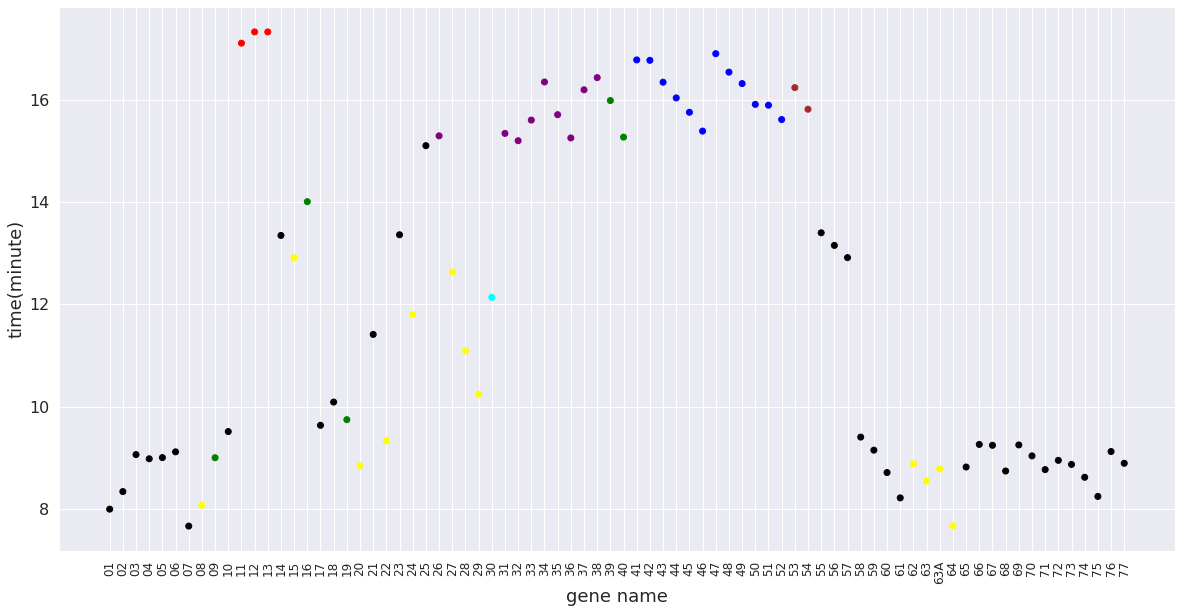

In [297]:
plt.figure(figsize=(20, 10))
plt.scatter(x = mean_average_time.index, y=list(mean_average_time['average_time']),c=list(mean_average_time["Colour"]))
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=16)
plt.xlabel('gene name',fontsize=18)
plt.ylabel('time(minute)',fontsize=18)
#plt.title('Average time of gene expression',fontsize=16
plt.savefig('Average time of gene expression_8',dpi=400)

### Result Datasets, they will hold the selected files and current notebook file


In [125]:
# Details of the analysis, please overwrite defaults and complete the description

title = 'kClustering analysis' # name your analysis
notes = '' # describe/comment this analysis

from obis_connector import NewDataSet 
 
datasets = [] 
 
analysed = NewDataSet( 
    name = title, 
    type = 'ANALYZED_DATA', 
    notes = notes, 
    files = analysisfile, 
    parents = resultDatasetParents 
) 
datasets.append(analysed) 
 
 
# When set to True the uploaded files will be moved into the default location inside working directory 
# that way subsequent analisis of OpenBIS DataSets will not need to download them before processing 
# It is safe to set it to True as the files are not deleted so they can be brought back 
moveFilesOnSuccess = True
 
 


### Save notebook before triggering upload and set upload = True below!

In [126]:
%%bash
# You should always call it before uploading data sets to record versions used
# Please only use scripts and annotations files from these folders so they will be tracked with the analysis
SCRIPTS=/homes2/openngs/openngs/scripts2
ANNOTATIONS=/homes2/openngs/openngs/annotation_files2

$SCRIPTS/check_dir_status.sh $SCRIPTS || exit 1
$SCRIPTS/check_dir_status.sh $ANNOTATIONS || exit 1



Checkig /homes2/openngs/openngs/scripts2
All content is recorded as:

## v.1.0.0...origin/v.1.0.0
commit a1f98fd5b01ca47dc385e31adf4830f58bfe8f72
Merge: 6a10f8d 9b8df5c
Author: Tomasz Zielinski <tomasz.zielinski@ed.ac.uk>
Date:   Tue Feb 19 15:58:26 2019 +0000

    Merge branch 'v.1.0.0' of git.ecdf.ed.ac.uk:sgrannem/openngs-scripts into v.1.0.0

Checkig /homes2/openngs/openngs/annotation_files2
All content is recorded as:

## master...origin/master
commit 18a74318524a6b71a7e60bfff4fbed3bb4193341
Author: Tomasz Zielinski <tomasz.zielinski@ed.ac.uk>
Date:   Tue Feb 19 15:59:22 2019 +0000

    added yeast gtf file


In [127]:
# Set upload to True to send data to OpenBIS (remember to save the Notebook first!!!!)
upload = True

#### You should not need to change anything below

In [128]:
%%javascript

require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});


<IPython.core.display.Javascript object>

In [129]:
# You should not need to change this

# Result Root node (selected in ELN dialog)
data_root= o.get_object('/OPENNGS/NGS_131')

# leave true to have new analysis container (sample/object) for the results DataSet (recommended),
# otherwise results become directly linked to data_root node you have selected at ELN dialog
new_container = True

if upload:
    jupyter_files = [fileName, obis_connector.save_snapshot(fileName)]
    analysis_props = {'name':title, 'notes':notes}
    
    res = obis_connector.upload_analysis_to_obis(datasets, 
                                  data_root = data_root,
                                  jupyter_files = jupyter_files,
                                  workspace = workspace, moveFilesOnSuccess = moveFilesOnSuccess,
                                  new_container = new_container,
                                  object_kind = 'JUPYTER_ANALYSIS', analysis_props = analysis_props)
    for ds in res: 
        print(ds.summary) 
else:
    raise ValueError('Save notebook and change upload to True to store results in OpenBIS')


Sample successfully created.
Uploading 'kClustering analysis' as DataSet ANALYZED_DATA
DataSet successfully created.
Uploaded 'kClustering analysis' as DataSet ANALYZED_DATA:20190219162514773-2797 took 0.0947969635328min, 0.0947969635328min/Mb
Moved following files to the dataset local folder: 20190219162514773-2797/original/DEFAULT
 mergedHittablesLPM76.txt,
 mergedHittablesLPM54.txt,
 mergedHittables_TPM_norm_76.txt,
 filteredatalognorm_LPM76.txt,
 Norm_to_TSB_LPM76_subtracted.txt,
 mergedHittables_TPM_norm_54.txt,
 filteredatalognorm_LPM54.txt,
 Norm_to_TSB_LPM54_subtracted.txt,
 Shift_experiment_LPM76_K-means_clusters.pdf,
 Shift_experiment_LPM54_K-means_clusters.pdf,
 Selected_table1.5_LPM76.txt,
 Shift_experiment_LPM76_selected_K-means_clusters_heatmap.pdf,
 Shift_experiment_LPM76_all_K-means_clusters_heatmap.pdf,
 Selected_table1.5_LPM54.txt,
 Shift_experiment_LPM54_selected_K-means_clusters_heatmap.pdf,
 Shift_experiment_LPM54_all_K-means_clusters_heatmap.pdf
attribute    value